In [1]:
## Some imports might be redundant because the code was split up into pieces
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from operator import itemgetter
from itertools import groupby
import seaborn as sns
from sklearn.model_selection import cross_val_score

In [2]:
# Set the plot size
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [4]:
# Read the data in pandas
data = pd.read_csv("data_for_student_case.csv")
data['bookingdate'] =  pd.to_datetime(data['bookingdate'])
data['creationdate'] =  pd.to_datetime(data['creationdate'])

# Delete the refused transactions (but keep them for later use maybe)
refused_data = data.loc[data['simple_journal'] == "Refused", :]
dataset = data.loc[data['simple_journal'] != "Refused", :]
dataset['bool_fraud'] = (dataset['simple_journal'] == "Chargeback").copy().astype(int)
dataset['bool_valid'] = (dataset['simple_journal'] == "Settled").copy().astype(int)

# Do some preprocessing for the ML algorithms
finalset = dataset.copy()
finalset['mail_id'] = finalset['mail_id'].str.replace('email','')
finalset['ip_id'] = finalset['ip_id'].str.replace('ip','')
finalset['card_id'] = finalset['card_id'].str.replace('card','')

# Group on dates
creation_dailygroup_mean = finalset.groupby(pd.Grouper(key='creationdate',freq='D')).mean()
creation_monthlygroup_mean = finalset.groupby(pd.Grouper(key='creationdate',freq='M')).mean()
booking_dailygroup_mean = finalset.groupby(pd.Grouper(key='bookingdate',freq='D')).mean()
booking_monthlygroup_mean = finalset.groupby(pd.Grouper(key='bookingdate',freq='M')).mean()

creation_dailygroup_sum = finalset.groupby(pd.Grouper(key='creationdate',freq='D')).sum()
creation_monthlygroup_sum = finalset.groupby(pd.Grouper(key='creationdate',freq='M')).sum()
booking_dailygroup_sum = finalset.groupby(pd.Grouper(key='bookingdate',freq='D')).sum()
booking_monthlygroup_sum = finalset.groupby(pd.Grouper(key='bookingdate',freq='M')).sum()

creation_dailygroup_count = finalset.groupby(pd.Grouper(key='creationdate',freq='D')).count()
creation_monthlygroup_count = finalset.groupby(pd.Grouper(key='creationdate',freq='M')).count()
booking_dailygroup_count = finalset.groupby(pd.Grouper(key='bookingdate',freq='D')).count()
booking_monthlygroup_count = finalset.groupby(pd.Grouper(key='bookingdate',freq='M')).count()

# Group on simple_journal
booking_monthlygroup_count = finalset.groupby(pd.Grouper(key='bookingdate',freq='M')).count()

# Group on ids
card_id_sum = finalset.groupby('card_id').sum()
ip_id_sum = finalset.groupby('ip_id').sum()
mail_id_sum = finalset.groupby('mail_id').sum()

accountcode_sum = finalset.groupby('accountcode').sum()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


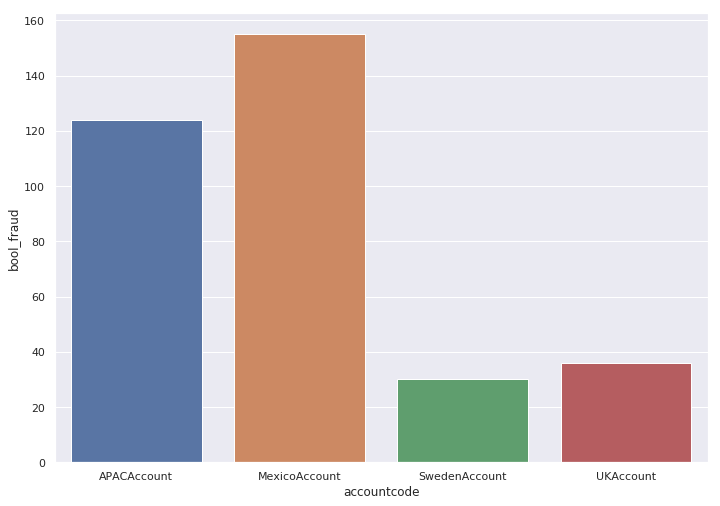

In [5]:
## Barplot account
sns.barplot(x=accountcode_sum.index, y="bool_fraud",data=accountcode_sum)

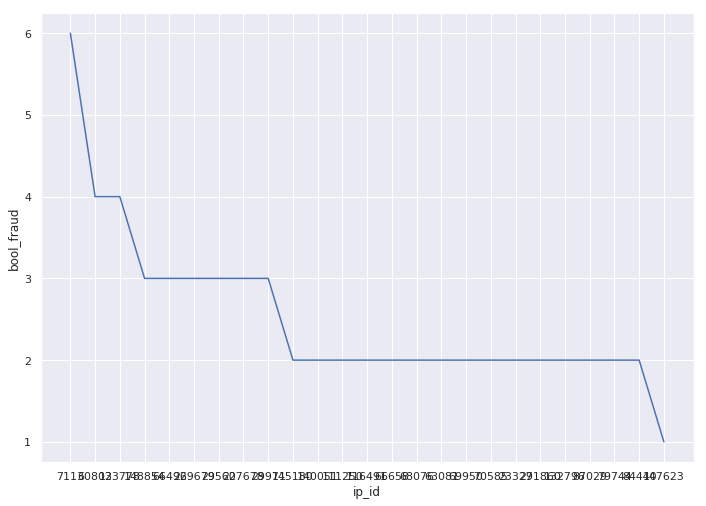

In [6]:
## Sorted ips
sorted_ips = ip_id_sum.sort_values("bool_fraud",ascending=False).head(25)
sns.lineplot(data=sorted_ips, x=sorted_ips.index, sort=False, y="bool_fraud")


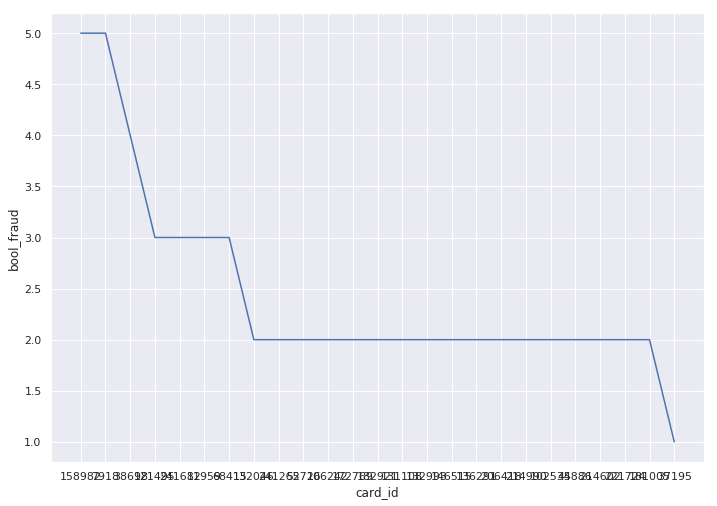

In [7]:
## Sorted on cards
sorted_cards = card_id_sum.sort_values("bool_fraud",ascending=False).head(25)
sns.lineplot(data=sorted_cards, x=sorted_cards.index, sort=False, y="bool_fraud")

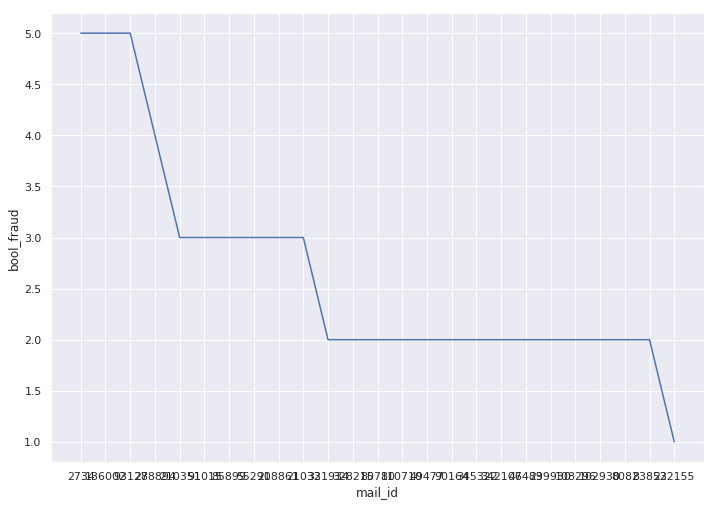

In [8]:
## Sorted on mails

sorted_cards = mail_id_sum.sort_values("bool_fraud",ascending=False).head(25)
sns.lineplot(data=sorted_cards, x=sorted_cards.index, sort=False, y="bool_fraud")

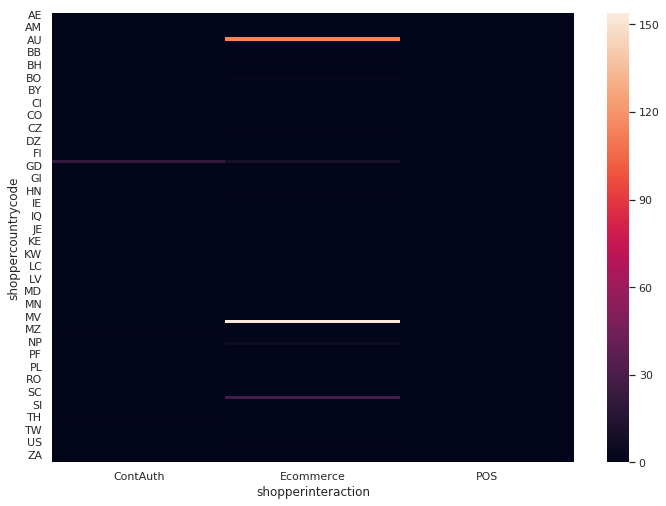

In [9]:
# Heatmap country and shopperinteraction
heatmap_data = pd.pivot_table(finalset, "simple_journal", "shoppercountrycode","shopperinteraction", aggfunc=lambda x: sum(x == "Chargeback"))
ax = sns.heatmap(heatmap_data.fillna(0))



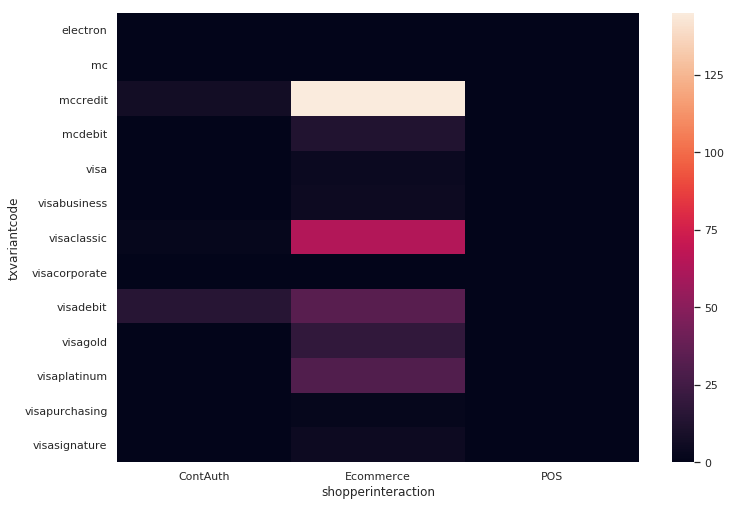

In [13]:
# Heatmap card type and shopperinteraction
heatmap_data = pd.pivot_table(finalset, "simple_journal", "txvariantcode","shopperinteraction", aggfunc=lambda x: sum(x == "Chargeback"))
ax = sns.heatmap(heatmap_data.fillna(0))

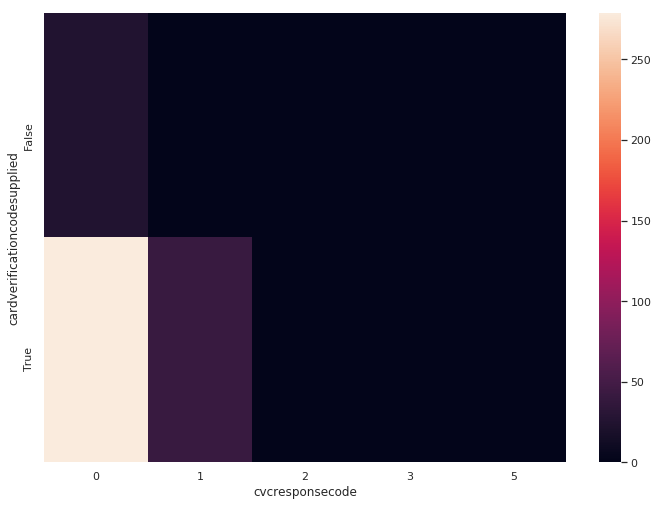

In [15]:
# Heatmap card type and shopperinteraction
heatmap_data = pd.pivot_table(finalset, "simple_journal", "cardverificationcodesupplied","cvcresponsecode", aggfunc=lambda x: sum(x == "Chargeback"))
ax = sns.heatmap(heatmap_data.fillna(0))

[Text(0, 0, '2015-07-31'),
 Text(0, 0, '2015-08-31'),
 Text(0, 0, '2015-09-30'),
 Text(0, 0, '2015-10-31')]

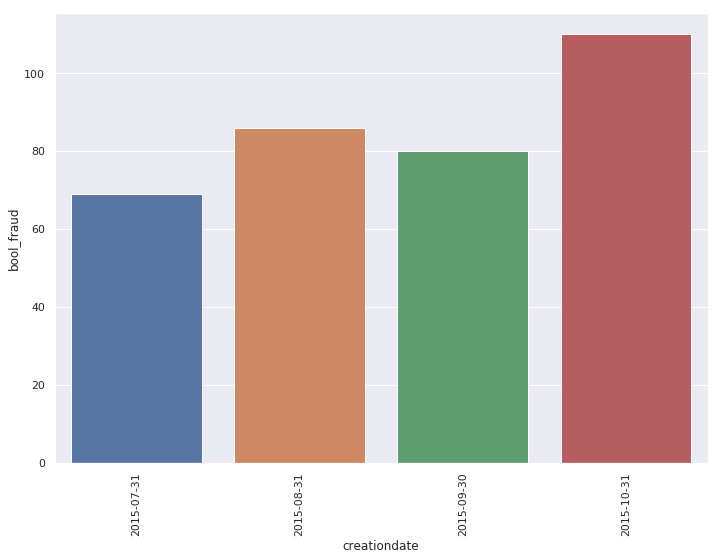

In [12]:
# Monthly fraud barplot
ax = sns.barplot(x=creation_monthlygroup_sum.index, y="bool_fraud", data=creation_monthlygroup_sum)
ax.set_xticklabels(labels = [d.date() for d in creation_monthlygroup_sum.index], rotation=90)